# Bayesian differential abundance testing

In [592]:
library(tidyverse)
library(glue)
library(brms)
library(furrr)
library(here)
library(future)
library(tidybayes)
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

In [593]:
load(here("rdata/data_mi.rds"))

In [594]:
# define the formula we use at the example of Bifidobacterium
formula_mu <- glue("Bifidobacterium ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
formula_sigma <- sigma ~ 1 + time*cc
formula <- bf(formula_mu, formula_sigma)
# see default priors brms
get_prior(formula, data = data_imp[[1]], family = student)
# we use default prior except for using a normal(0, 1) prior for the b
# which makes the model more skeptical of large effect sizes

prior,class,coef,group,resp,dpar,nlpar,bound
"student_t(3, 7, 10)",Intercept,,,,,,
,b,,,,,,
,b,age_d_s,,,,,
,b,bf_count_s,,,,,
,b,ccyes,,,,,
,b,csection1,,,,,
,b,sibling1,,,,,
,b,sibling1:csection1,,,,,
,b,timepost,,,,,
,b,timepost:ccyes,,,,,


In [597]:
core <- c(
    "Bifidobacterium", 
    "Enterococcus", 
    "Streptococcusbovisetrel", 
    "Streptococcusmitisetrel", 
    "Streptococcusintermediusetrel",
    "Granulicatella"
)

In [603]:
genera <- colnames(data_imp[[1]])[29:158]

In [351]:
models <- map(test_genus, function(genus) {
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc
    formula <- bf(formula_mu, formula_sigma)
    
    # fit example model
    fit <- brm(
        data = data_imp[[1]],
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = here(glue("models/test_{genus}_tt"))
    ) 
})

Compiling the C++ model
Start sampling
Compiling the C++ model
Start sampling
Compiling the C++ model
Start sampling
Compiling the C++ model
recompiling to avoid crashing R session
Start sampling
Compiling the C++ model
Start sampling
Compiling the C++ model
Start sampling


In [604]:
#map(models, summary)
map2(models, test_genus, return_diag)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

In [361]:
#map(models, pp_check)

In [396]:

counts <- data_imp[[1]] %>% group_by(cc, time, sibling, csection) %>% summarise(n = n())
counts
cov <- data_imp[[1]] %>% 
    group_by(cc, time, sibling, csection) %>% 
    summarise(age = mean(age_d_s), bf = mean(bf_count_s)) %>%
    mutate_if(is.numeric, round, 2)
cov

cc,time,sibling,csection,n
no,pre,0,0,16
no,pre,0,1,1
no,pre,1,0,30
no,pre,1,1,2
no,post,0,0,16
no,post,0,1,1
no,post,1,0,30
no,post,1,1,2
yes,pre,0,0,19
yes,pre,0,1,4


`mutate_if()` ignored the following grouping variables:
Columns `cc`, `time`, `sibling`


cc,time,sibling,csection,age,bf
no,pre,0,0,-0.97,0.15
no,pre,0,1,-0.76,0.38
no,pre,1,0,-1.08,0.42
no,pre,1,1,-0.81,0.78
no,post,0,0,0.51,-0.55
no,post,0,1,0.73,0.30
no,post,1,0,0.41,-0.25
no,post,1,1,0.55,0.37
yes,pre,0,0,-0.18,0.12
yes,pre,0,1,-0.22,0.21


In [ ]:
# homepre
home_pre_nosib_nocsec <- b_Intercept * 16/49
home_pre_nosib_csec <- (b_Intercept + b_csection1) * 1/49
home_pre_sib_nocsec <- (b_Intercept + b_sibling1) * 30/49
home_pre_sib_csec <- (b_Intercept + b_sibling1 + b_csection1 + "b_sibling1:csection1") * 2/49
homepre <- home_pre_nosib_nocsec + home_pre_nosib_csec + home_pre_sib_nocsec + home_pre_sib_csec

# homepost
home_post_nosib_nocsec <- (b_Intercept + b_timepost) * 16/49
home_post_nosib_csec <- (b_Intercept + b_timepost + b_csection1) * 1/49
home_post_sib_nocsec <- (b_Intercept + b_timepost + b_sibling1) * 30/49
home_post_sib_csec <- (b_Intercept + b_timepost + b_sibling1 + csection1 + "b_sibling1:csection1") * 2/49
homepost <- home_post_nosib_nocsec + home_post_nosib_csec + home_post_sib_nocsec + home_post_sib_csec

# ccpre
cc_pre_nosib_nocsec <- (b_Intercept + b_ccyes) * 19/49
cc_pre_nosib_csec <- (b_Intercept + b_ccyes + b_csection1) * 4/49
cc_pre_sib_nocsec <- (b_Intercept + b_ccyes + b_sibling1) * 24/49
cc_pre_sib_csec <- (b_Intercept + b_ccyes + b_sibling1 + b_csection1 + "b_sibling1:csection1") * 2/49
ccpre <- cc_pre_nosib_nocsec + cc_pre_nosib_csec + cc_pre_sib_nocsec + cc_pre_sib_csec

# ccpost
cc_post_nosib_nocsec <- (b_Intercept + b_ccyes + b_timepost) * 19/49
cc_post_nosib_csec <- (b_Intercept + b_ccyes + b_timepost + b_csection1) * 4/49
cc_post_sib_nocsec <- (b_Intercept + b_ccyes + b_timepost + b_sibling1) * 24/49
cc_post_sib_csec <- (b_Intercept + b_ccyes + b_timepost + b_sibling1 + b_csection1 + "b_sibling1:csection1") * 2/49
ccpost <- cc_post_nosib_nocsec + cc_post_nosib_csec + cc_post_sib_nocsec + cc_post_sib_csec

In [577]:
post <- map2(models, test_genus, function(fit, genus) {
   # calculate posterior means of interest
    posterior_samples(fit) %>%
        mutate(
            # homepre
            home_pre_nosib_nocsec = b_Intercept * 16/49,
            home_pre_nosib_csec = (b_Intercept + b_csection1) * 1/49,
            home_pre_sib_nocsec = (b_Intercept + b_sibling1) * 30/49,
            home_pre_sib_csec = (b_Intercept + b_sibling1 + b_csection1 + `b_sibling1:csection1`) * 2/49,
            homepre = home_pre_nosib_nocsec + home_pre_nosib_csec + home_pre_sib_nocsec + home_pre_sib_csec,

            # homepost
            home_post_nosib_nocsec = (b_Intercept + b_timepost) * 16/49,
            home_post_nosib_csec = (b_Intercept + b_timepost + b_csection1) * 1/49,
            home_post_sib_nocsec = (b_Intercept + b_timepost + b_sibling1) * 30/49,
            home_post_sib_csec = (b_Intercept + b_timepost + b_sibling1 + b_csection1 + `b_sibling1:csection1`) * 2/49,
            homepost = home_post_nosib_nocsec + home_post_nosib_csec + home_post_sib_nocsec + home_post_sib_csec,

            # ccpre
            cc_pre_nosib_nocsec = (b_Intercept + b_ccyes) * 19/49,
            cc_pre_nosib_csec = (b_Intercept + b_ccyes + b_csection1) * 4/49,
            cc_pre_sib_nocsec = (b_Intercept + b_ccyes + b_sibling1) * 24/49,
            cc_pre_sib_csec = (b_Intercept + b_ccyes + b_sibling1 + b_csection1 + `b_sibling1:csection1`) * 2/49,
            ccpre = cc_pre_nosib_nocsec + cc_pre_nosib_csec + cc_pre_sib_nocsec + cc_pre_sib_csec,

            # ccpost
            cc_post_nosib_nocsec = (b_Intercept + b_ccyes + b_timepost) * 19/49,
            cc_post_nosib_csec = (b_Intercept + b_ccyes + b_timepost + b_csection1) * 4/49,
            cc_post_sib_nocsec = (b_Intercept + b_ccyes + b_timepost + b_sibling1) * 24/49,
            cc_post_sib_csec = (b_Intercept + b_ccyes + b_timepost + b_sibling1 + b_csection1 + `b_sibling1:csection1`) * 2/49,
            ccpost = cc_post_nosib_nocsec + cc_post_nosib_csec + cc_post_sib_nocsec + cc_post_sib_csec,
            
            # csection 
            csec_home_pre_nosib = (b_Intercept + b_csection1) * 1/18,
            csec_home_pre_sib = (b_Intercept + b_sibling1 + b_csection1 + `b_sibling1:csection1`) * 2/18,
            csec_home_post_nosib = (b_Intercept + b_timepost + b_csection1) * 1/18,
            csec_home_post_sib = (b_Intercept + b_timepost + b_sibling1 + b_csection1 + `b_sibling1:csection1`) * 2/18,
            csec_cc_pre_nosib = (b_Intercept + b_ccyes + b_csection1) * 4/18,
            csec_cc_pre_sib = (b_Intercept + b_ccyes + b_sibling1 + b_csection1 + `b_sibling1:csection1`) * 2/18,
            csec_cc_post_nosib = (b_Intercept + b_ccyes + b_timepost + b_csection1) * 4/18,
            csec_cc_post_sib = (b_Intercept + b_ccyes + b_timepost + b_sibling1 + b_csection1 + `b_sibling1:csection1`) * 2/18,

            # no csection 
            nocsec_home_pre_nosib = (b_Intercept) * 16/178,
            nocsec_home_pre_sib = (b_Intercept + b_sibling1) * 30/178,
            nocsec_home_post_nosib = (b_Intercept + b_timepost) * 16/178,
            nocsec_home_post_sib = (b_Intercept + b_timepost + b_sibling1) * 30/178,
            nocsec_cc_pre_nosib = (b_Intercept + b_ccyes) * 19/178,
            nocsec_cc_pre_sib = (b_Intercept + b_ccyes + b_sibling1) * 24/178,
            nocsec_cc_post_nosib = (b_Intercept + b_ccyes + b_timepost) * 19/178,
            nocsec_cc_post_sib = (b_Intercept + b_ccyes + b_timepost + b_sibling1) * 24/178,
            
            nocsec = (nocsec_home_pre_nosib + nocsec_home_pre_sib + nocsec_home_post_nosib + nocsec_home_post_sib +
                      nocsec_cc_pre_nosib + nocsec_cc_pre_sib + nocsec_cc_post_nosib + nocsec_cc_post_sib),
            
            csec = (nocsec_home_pre_nosib + nocsec_home_pre_sib + nocsec_home_post_nosib + nocsec_home_post_sib +
                      nocsec_cc_pre_nosib + nocsec_cc_pre_sib + nocsec_cc_post_nosib + csec_cc_post_sib), 


            # mu diff
            ccpre_homepre = ccpre - homepre,
            ccpost_homepost = ccpost - homepost,
            ccpost_ccpre = ccpost - ccpre,
            homepost_homepre = homepost - homepre,
            csec_nocsec = csec - nocsec,
            
            
            # store genus
            genus = genus

        ) %>%
    select(genus, ccpre_homepre, ccpost_homepost, ccpost_ccpre, homepost_homepre, csec_nocsec, nocsec, csec)
})

post <- map_dfr(post, bind_rows)

In [578]:
post %>% head()

genus,ccpre_homepre,ccpost_homepost,ccpost_ccpre,homepost_homepre,csec_nocsec,nocsec,csec
Bifidobacterium,-0.13442090,-0.13442090,0.07866461,0.07866461,-0.1481018,6.424303,6.276201
Bifidobacterium,0.13960723,0.13960723,0.05214964,0.05214964,-0.1820021,6.513650,6.331648
Bifidobacterium,-0.11211847,-0.11211847,0.16482612,0.16482612,-0.1628700,6.438434,6.275564
Bifidobacterium,0.06245942,0.06245942,0.14277923,0.14277923,-0.1940268,6.597277,6.403250
Bifidobacterium,-0.06267974,-0.06267974,-0.01042232,-0.01042232,-0.1531970,6.534283,6.381086
Bifidobacterium,0.07461143,0.07461143,0.45108128,0.45108128,-0.1918398,6.615893,6.424053


In [579]:
# summarise post 
post_sum <- post %>% 
        gather(comparison, value, -genus) %>%
        group_by(genus, comparison) %>%
        mean_hdi() %>%
        mutate_if(is.numeric, round, 2) 

# nest for plotting
post_nested <- post %>% 
        gather(comparison, value, -genus) %>%
        group_by(comparison)  %>%
        nest()

`mutate_if()` ignored the following grouping variables:
Column `genus`


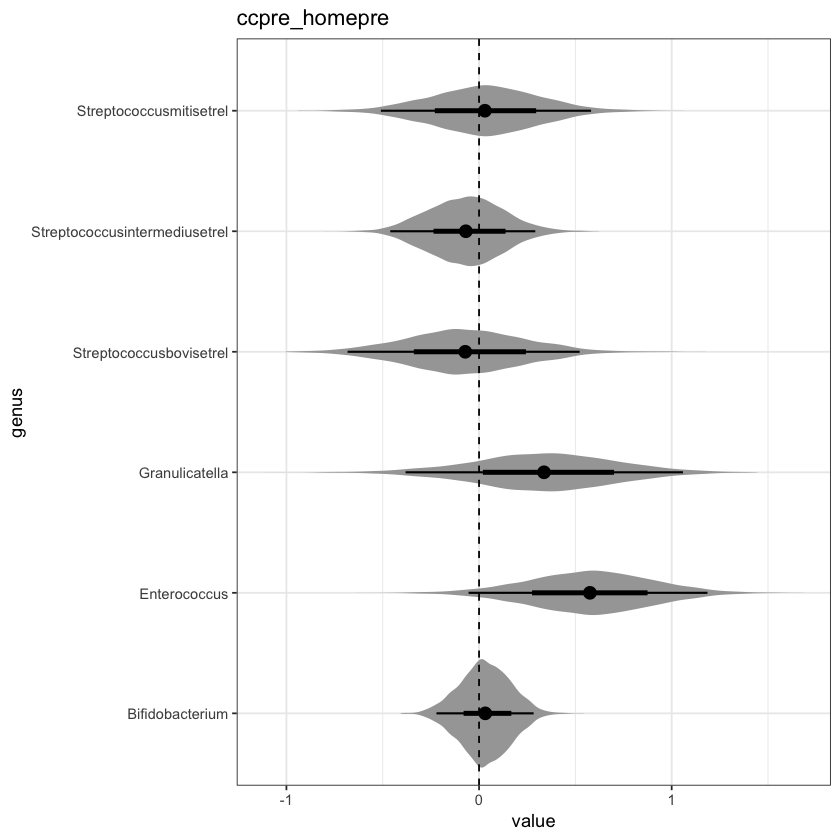

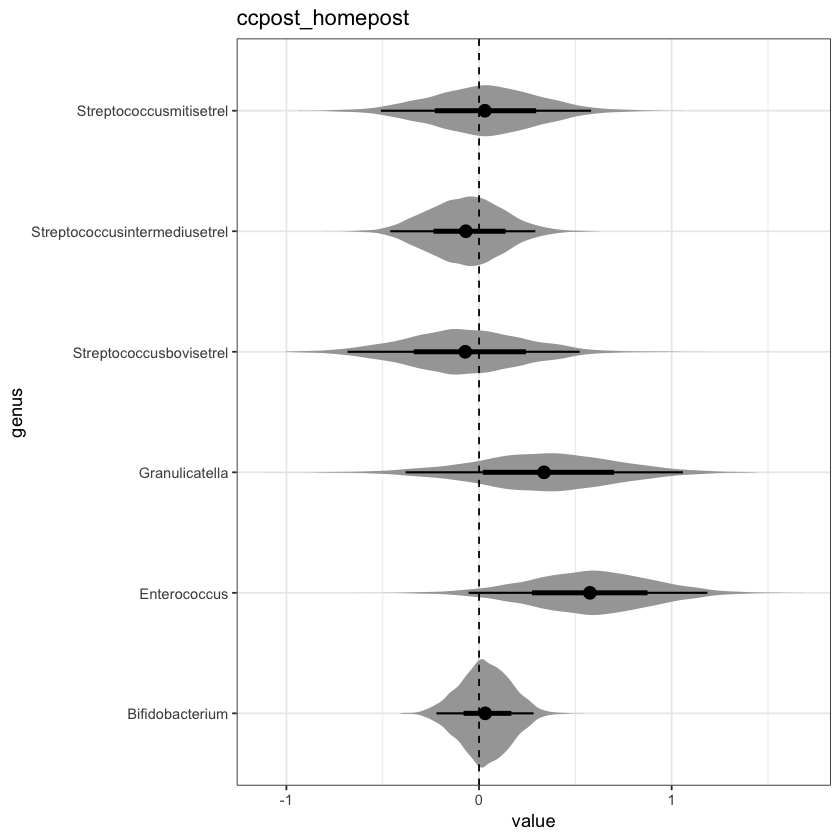

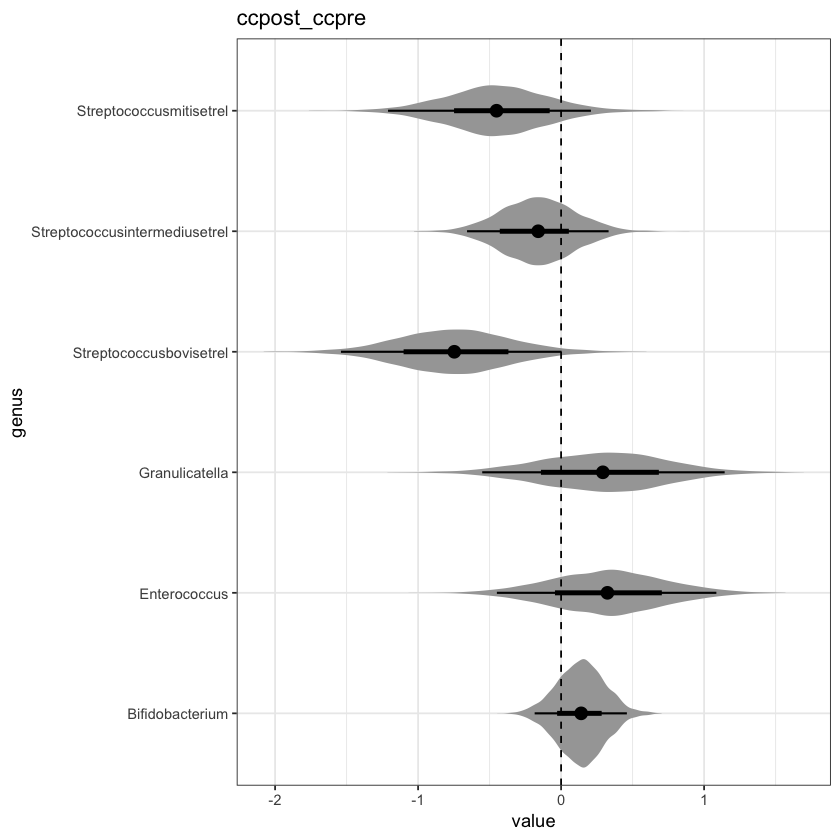

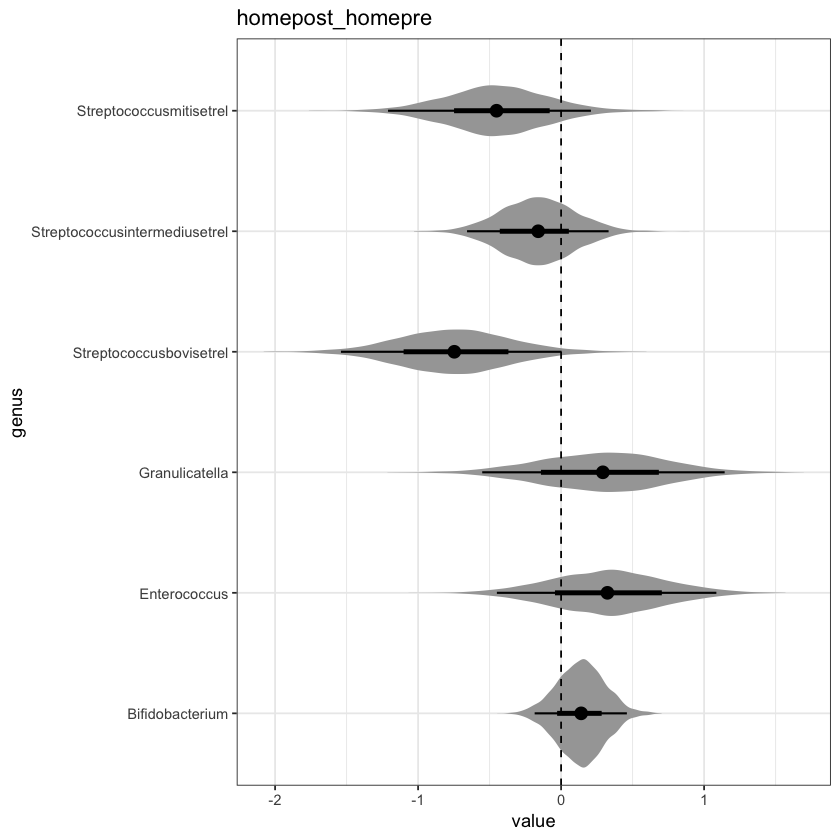

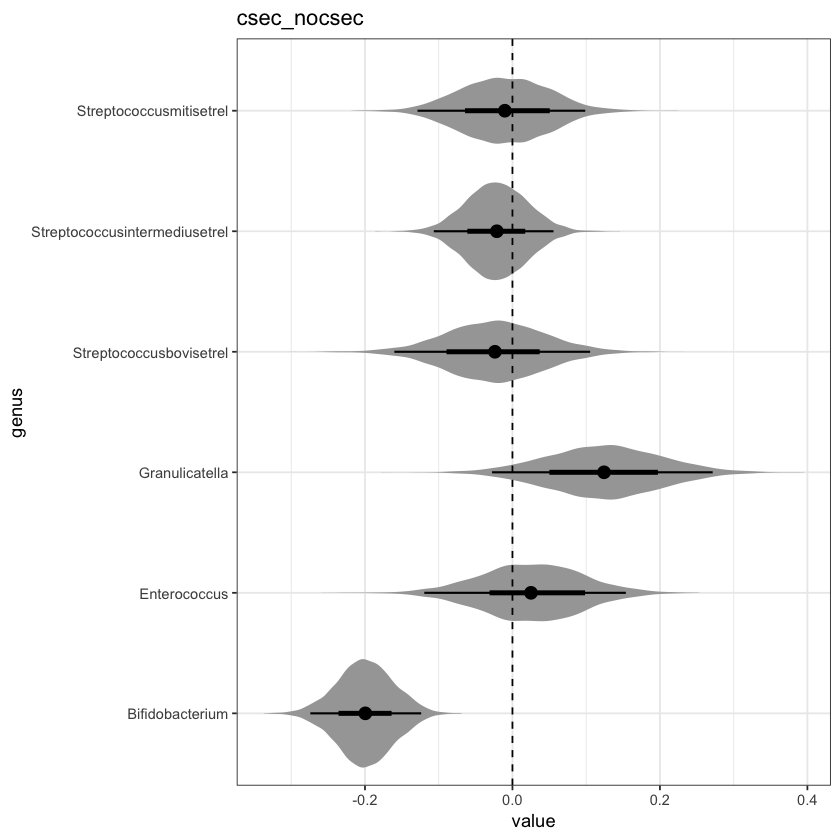

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]


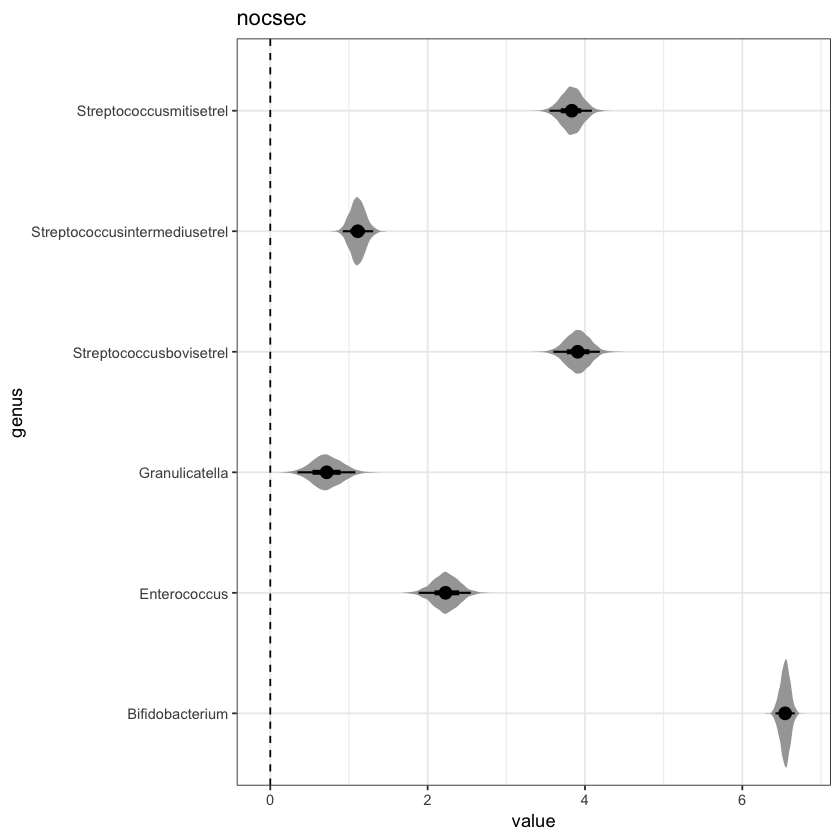

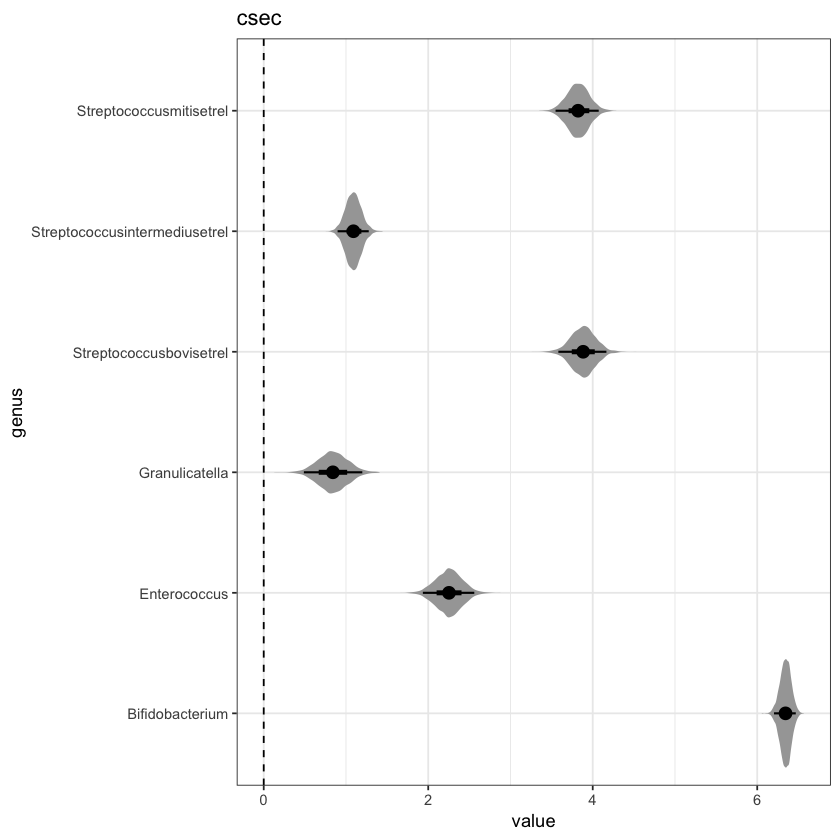

In [580]:
map2(post_nested$data, post_nested$comparison, function(data, title) {
    ggplot(data, aes(value, genus)) +
        geom_eyeh(point_interval = mean_hdi) +
        geom_vline(aes(xintercept = 0), linetype = "dashed") +
        ggtitle(title) +
        theme_bw()
})

In [581]:
#fitted(models[[1]], newdata = tibble(cc = "no", time = "pre", sibling = 0, csection = 0, subject_id = "201"))

In [582]:
data_imp[[1]] %>% group_by(cc, time) %>% summarise(mean = mean(Bifidobacterium))

cc,time,mean
no,pre,6.103913
no,post,5.971813
yes,pre,5.931904
yes,post,6.338181


In [378]:
genus <- "Bifidobacterium"
test <- brm(
    data = data_imp[[1]],
    family = student(),
    formula = bf(Bifidobacterium ~ cc * time, formula_sigma),
    prior = c(prior(normal(0, 1), class = b),
              prior(normal(0, 4), class = Intercept, dpar = sigma),
              prior(normal(0, 0.2), class = b, dpar = sigma), 
              prior(gamma(2, 0.2), class = nu)),
    cores = 4,
    file = here(glue("models/test_{genus}_tt2"))
) 

Compiling the C++ model
Start sampling


In [385]:
summary(test)

 Family: student 
  Links: mu = identity; sigma = log; nu = identity 
Formula: Bifidobacterium ~ cc * time 
         sigma ~ 1 + time * cc
   Data: data_imp[[1]] (Number of observations: 196) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
                     Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept                6.64      0.07     6.49     6.78       3323 1.00
sigma_Intercept         -0.91      0.15    -1.20    -0.61       3067 1.00
ccyes                   -0.03      0.12    -0.27     0.20       2772 1.00
timepost                -0.16      0.11    -0.38     0.05       3113 1.00
ccyes:timepost           0.10      0.17    -0.22     0.45       2551 1.00
sigma_timepost           0.01      0.14    -0.27     0.28       3483 1.00
sigma_ccyes              0.13      0.15    -0.16     0.41       3755 1.00
sigma_timepost:ccyes    -0.06      0.16    -0.38     0.26       3173 1.00

Fam

In [397]:
summary(models[[1]])

 Family: student 
  Links: mu = identity; sigma = log; nu = identity 
Formula: Bifidobacterium ~ time * cc + age_d_s + bf_count_s + sibling * csection + (1 | subject_id) 
         sigma ~ 1 + time * cc
   Data: data_imp[[1]] (Number of observations: 196) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~subject_id (Number of levels: 98) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.33      0.06     0.20     0.45        504 1.01

Population-Level Effects: 
                     Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept                6.44      0.13     6.18     6.69       2411 1.00
sigma_Intercept         -1.32      0.19    -1.69    -0.93       1317 1.00
timepost                 0.14      0.17    -0.19     0.46       2282 1.00
ccyes                    0.08      0.13    -0.18     0.33       2426 1.00
age_d_s                 -0.16      0.09    -

In [413]:
models_s <- map(test_genus, function(genus) {
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc
    formula <- bf(formula_mu, formula_sigma)
    
    # fit example model
    fit <- brm(
        data = data_imp[[1]],
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = here(glue("models/test_{genus}_tt22"))
    ) 
})

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling
Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [416]:
models_s[[1]]

 Family: student 
  Links: mu = identity; sigma = log; nu = identity 
Formula: Bifidobacterium ~ cc * time 
         sigma ~ 1 + time * cc
   Data: data_imp[[1]] (Number of observations: 196) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
                     Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept                6.64      0.07     6.49     6.78       3323 1.00
sigma_Intercept         -0.91      0.15    -1.20    -0.61       3067 1.00
ccyes                   -0.03      0.12    -0.27     0.20       2772 1.00
timepost                -0.16      0.11    -0.38     0.05       3113 1.00
ccyes:timepost           0.10      0.17    -0.22     0.45       2551 1.00
sigma_timepost           0.01      0.14    -0.27     0.28       3483 1.00
sigma_ccyes              0.13      0.15    -0.16     0.41       3755 1.00
sigma_timepost:ccyes    -0.06      0.16    -0.38     0.26       3173 1.00

Fam

In [444]:
posterior_predict(models[[1]]) %>% as_tibble() %>% gather(subject, predictions) %>%
    arrange(predictions)

subject,predictions
V43,-34966.612
V13,-28333.147
V61,-23981.481
V6,-17262.050
V54,-9121.314
V54,-6521.261
V144,-5715.713
V119,-4989.805
V188,-3170.439
V6,-2628.190


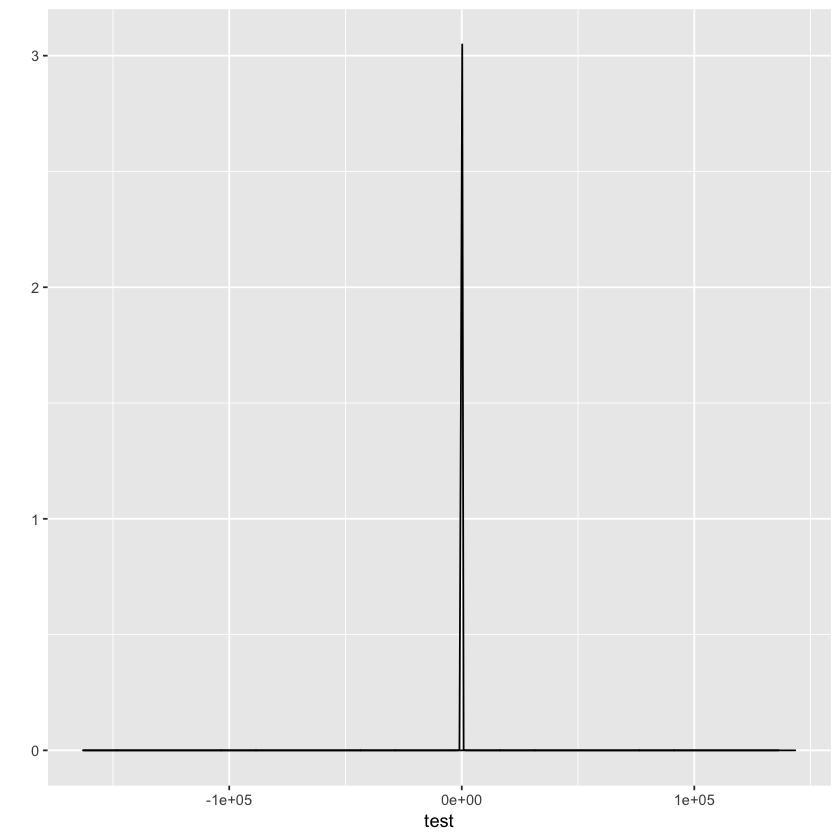

In [451]:
test <- rt(df = 1, n = 784000) * 1 + 6
qplot(test, geom = "density")

In [501]:
fit_t <- brm(
    data = data_imp[[1]],
    family = student(),
    formula = bf(formula_mu, formula_sigma),
    prior = c(prior(normal(0, 1), class = b),
              prior(normal(0, 4), class = Intercept, dpar = sigma),
              prior(normal(0, 0.2), class = b, dpar = sigma), 
              prior(uniform(0, 50) + 3, class = nu)),
    file = here(glue("models/test_Bifidobacterium_priot32332222"))
)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '6df5496b0474bf181b29e8df7d74e2ef' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000515 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 5.15 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.80532 seconds (Warm-up)
Chain 1:                1.5692 seconds (Sampling)
Ch

Using 10 posterior samples for ppc type 'dens_overlay' by default.


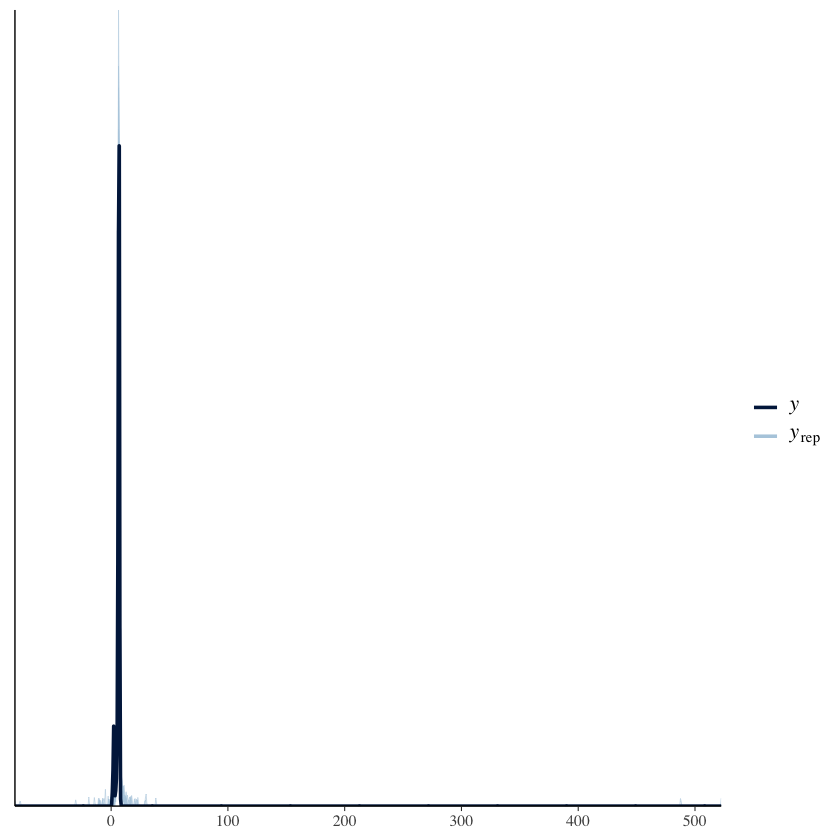

In [502]:
pp_check(fit_t)

In [487]:
map(models, summary)

[[1]]
 Family: student 
  Links: mu = identity; sigma = log; nu = identity 
Formula: Bifidobacterium ~ time * cc + age_d_s + bf_count_s + sibling * csection + (1 | subject_id) 
         sigma ~ 1 + time * cc
   Data: data_imp[[1]] (Number of observations: 196) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~subject_id (Number of levels: 98) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.33      0.06     0.20     0.45        504 1.01

Population-Level Effects: 
                     Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept                6.44      0.13     6.18     6.69       2411 1.00
sigma_Intercept         -1.32      0.19    -1.69    -0.93       1317 1.00
timepost                 0.14      0.17    -0.19     0.46       2282 1.00
ccyes                    0.08      0.13    -0.18     0.33       2426 1.00
age_d_s                 -0.16      0.0

In [529]:
nd <- with(data_imp[[1]], 
           expand.grid(cc = levels(cc), time = levels(time),
                       sibling = levels(sibling), csection = levels(csection)))
nd$bf_count_s <- median(model.frame(fit_t)$bf_count_s)
nd$age_d_s <- median(model.frame(fit_t)$age_d_s)
nd$bf_count_s <- 0
nd$age_d_s <- 0

In [530]:
fitted(fit_t, newdata = nd, allow_new_levels = T, summary = F) %>% dim()

[1] 4000   16

In [531]:
nd

cc,time,sibling,csection,bf_count_s,age_d_s
no,pre,0,0,0,0
yes,pre,0,0,0,0
no,post,0,0,0,0
yes,post,0,0,0,0
no,pre,1,0,0,0
yes,pre,1,0,0,0
no,post,1,0,0,0
yes,post,1,0,0,0
no,pre,0,1,0,0
yes,pre,0,1,0,0


In [564]:
plinp <- posterior_linpred(models[[1]], nd, transform = T,  re.form = ~ 0) %>% as_tibble()
colnames(plinp) <- c(
    "home_pre_nosib_nocsec",
    "cc_pre_nosib_nocsec",
    "home_post_nosib_nocsec",
    "cc_post_nosib_nocsec",
    "home_pre_sib_nocsec",
    "cc_pre_sib_nocsec",
    "home_post_sib_nocsec", 
    "cc_post_sib_nocsec",
    "home_pre_nosib_csec",
    "cc_pre_nosib_csec", 
    "home_post_nosib_csec",
    "cc_post_nosib_csec",
    "home_pre_sib_csec",
    "cc_pre_sib_csec",
    "home_post_sib_csec",
    "cc_post_sib_csec"
)

In [587]:
plinp %>% head()
plinp %>% mutate(
            homepre = (home_pre_nosib_nocsec + home_pre_nosib_csec + home_pre_sib_nocsec + home_pre_sib_csec)/4,
            homepost = (home_post_nosib_nocsec + home_post_nosib_csec + home_post_sib_nocsec + home_post_sib_csec)/4,
            ccpre = (cc_pre_nosib_nocsec + cc_pre_nosib_csec + cc_pre_sib_nocsec + cc_pre_sib_csec)/4,
            ccpost = (cc_post_nosib_nocsec + cc_post_nosib_csec + cc_post_sib_nocsec + cc_post_sib_csec)/4) %>%
    mutate(ccpost_homepost = ccpost - homepost,
           ccpost_ccpre = ccpost -ccpre,
           ccpre_homepre = ccpre - homepre) %>%
    select(ccpost_homepost, ccpost_ccpre, ccpre_homepre) %>%
    gather(comparison, value) %>%
    group_by(comparison) %>%
    mean_hdi()
plinp %>% gather(subgroup, value) %>%
    group_by(subgroup) %>%
    mean_hdi()

home_pre_nosib_nocsec,cc_pre_nosib_nocsec,home_post_nosib_nocsec,cc_post_nosib_nocsec,home_pre_sib_nocsec,cc_pre_sib_nocsec,home_post_sib_nocsec,cc_post_sib_nocsec,home_pre_nosib_csec,cc_pre_nosib_csec,home_post_nosib_csec,cc_post_nosib_csec,home_pre_sib_csec,cc_pre_sib_csec,home_post_sib_csec,cc_post_sib_csec
6.373291,6.303092,6.451956,6.673709,6.448440,6.378241,6.527105,6.748858,5.474637,5.404437,5.553301,5.775055,6.493964,6.423765,6.572629,6.794383
6.528292,6.691141,6.580442,6.759835,6.331509,6.494358,6.383658,6.563051,5.755110,5.917959,5.807260,5.986653,6.091059,6.253908,6.143208,6.322601
6.357377,6.268394,6.522203,6.601216,6.425999,6.337016,6.590825,6.669838,6.116735,6.027752,6.281561,6.360574,6.348203,6.259220,6.513029,6.592042
6.430225,6.543677,6.573004,6.666582,6.497550,6.611002,6.640329,6.733907,5.731993,5.845445,5.874772,5.968350,6.193127,6.306579,6.335906,6.429484
6.488577,6.491146,6.478155,6.802945,6.570451,6.573019,6.560029,6.884819,5.586608,5.589176,5.576186,5.900976,6.592681,6.595250,6.582259,6.907049
6.295444,6.435531,6.746525,6.917750,6.340316,6.480403,6.791398,6.962622,5.315755,5.455842,5.766836,5.938061,6.093513,6.233600,6.544595,6.715819


comparison,value,.lower,.upper,.width,.point,.interval
ccpost_ccpre,0.26508388,-0.06625555,0.5905809,0.95,mean,hdi
ccpost_homepost,0.20329840,-0.02673416,0.4562393,0.95,mean,hdi
ccpre_homepre,0.07855331,-0.16994561,0.3361801,0.95,mean,hdi


subgroup,value,.lower,.upper,.width,.point,.interval
cc_post_nosib_csec,6.020067,5.522403,6.559627,0.95,mean,hdi
cc_post_nosib_nocsec,6.779922,6.467064,7.051430,0.95,mean,hdi
cc_post_sib_csec,6.403356,5.733381,7.072755,0.95,mean,hdi
cc_post_sib_nocsec,6.778711,6.531174,7.017748,0.95,mean,hdi
cc_pre_nosib_csec,5.754984,5.233303,6.257350,0.95,mean,hdi
cc_pre_nosib_nocsec,6.514838,6.295933,6.734481,0.95,mean,hdi
cc_pre_sib_csec,6.138272,5.434592,6.803722,0.95,mean,hdi
cc_pre_sib_nocsec,6.513627,6.271836,6.739362,0.95,mean,hdi
home_post_nosib_csec,5.816769,5.301503,6.350225,0.95,mean,hdi
home_post_nosib_nocsec,6.576624,6.320025,6.823365,0.95,mean,hdi


In [572]:
post %>% filter(genus == "Bifidobacterium") %>% 
    select(-genus) %>%
    gather(subgroup, value) %>%
    group_by(subgroup) %>%
    mean_hdi()


subgroup,value,.lower,.upper,.width,.point,.interval
ccpost_ccpre,0.14033878,-0.1849512,0.4600204,0.95,mean,hdi
ccpost_homepost,0.03217987,-0.2211741,0.2833221,0.95,mean,hdi
ccpre_homepre,0.03217987,-0.2211741,0.2833221,0.95,mean,hdi
csec,6.34413182,6.2040526,6.4685775,0.95,mean,hdi
csec_nocsec,0.19954053,0.1237707,0.2740804,0.95,mean,hdi
homepost_homepre,0.14033878,-0.1849512,0.4600204,0.95,mean,hdi
nocsec,6.54367235,6.4205433,6.6658707,0.95,mean,hdi


In [552]:
posterior_samples(models[1])  %>% select(b_ccyes, b_sibling1, b_csection1) %>% summarise_all(c(mean, sd))

b_ccyes_fn1,b_sibling1_fn1,b_csection1_fn1,b_ccyes_fn2,b_sibling1_fn2,b_csection1_fn2
0.07855331,-0.001210902,-0.7598546,0.1308462,0.1057739,0.2637425


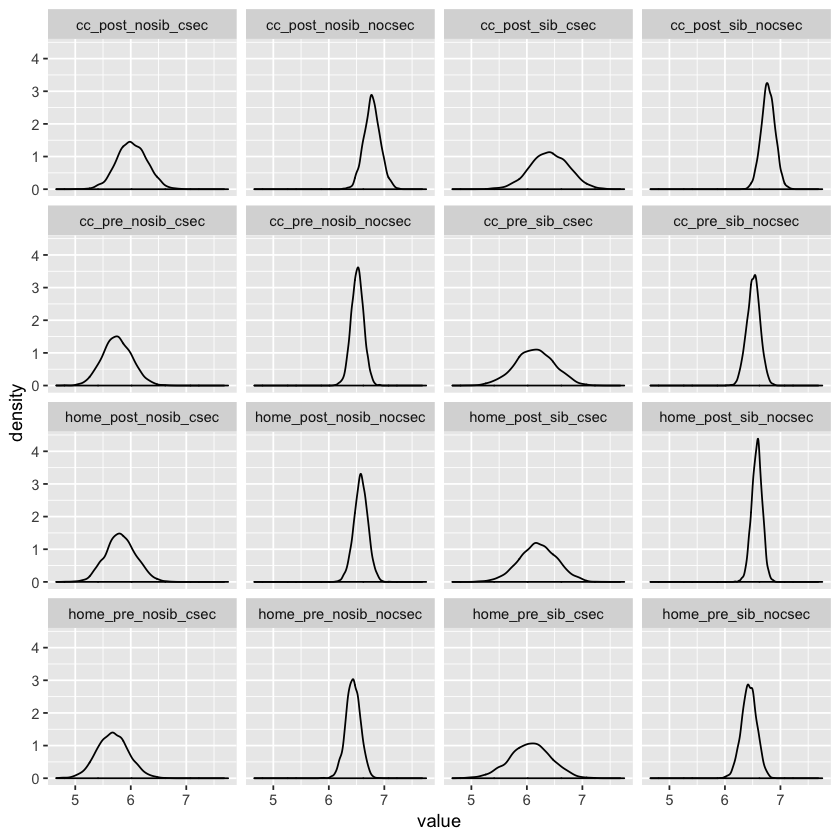

In [591]:
plinp %>% gather() %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~key)